# Unsupervised Learning: Netflix Film Clustering

In this notebook, I explore clustering algorithms including Kmeans, AgglomerativeClustering, and Gaussian mixture to cluster similar film titles together. I also explore various dimensinality reduction techniques including PCA, TSNE, and UMAP. A link to the data can be found below.

https://www.kaggle.com/datasets/brajrajs/netflix-titles

Github:https://github.com/Vedhik-Kodav/Netflix-Unsupervised-Learning

In [22]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import umap
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn import metrics

In [61]:
netflix=pd.read_csv('netflix_titles.csv')

In [62]:
netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [25]:
netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [63]:
netflix.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [69]:
netflix=netflix.drop(columns='description')

### Methods:

I first cleaned the data to only include the important features by dropping the show ID, title, director, date added to netflix, and duration features. I also turned the cast, countries, unique genres, released year, and rating into dummy columns. Although there are many null director records, I do not drop this because I will create dummy columns for the most common directors. There are 36,439 unique cast members, so creating dummy columns for every single one would provide poor clustering and too much interference given that most actors had very few films on netflix. To combat this, I only included dummy columns for actors that were cast in 15 unique titles. This gave 72 dummy columns. The same method was performed for countries as well to include only the top 17 countries by title count. I created dummy columns for the released year based on ranges of years: <=2000, 2001-2005, 2006-2010, 2011-2015, 2015-2020, and >=2021. I created dummy columns for every genre and rating. 

In [70]:

#too many unique directors with not enough movies per director to provide significant clustering ability
netflix['director'].value_counts()

Rajiv Chilaka                     19
Raúl Campos, Jan Suter            18
Marcus Raboy                      16
Suhas Kadav                       16
Jay Karas                         14
                                  ..
Raymie Muzquiz, Stu Livingston     1
Joe Menendez                       1
Eric Bross                         1
Will Eisenberg                     1
Mozez Singh                        1
Name: director, Length: 4528, dtype: int64

In [71]:
cast=(netflix['cast'].unique())

cast_cleaned=[]
for i in range(len(cast)):
    try:
        cast[i]=cast[i].split(', ')
        for j in cast[i]:
            cast_cleaned.append(j) 

    except:
        continue

unique_cast=[]
for i in cast_cleaned:
    if i not in unique_cast:
        unique_cast.append(i)
    else:
        continue

In [72]:
#there are way too many unique cast members for significance in clustering
len(unique_cast)

36439

In [73]:
#we'll only include the most popular actors on netflix with greater than 15 movies on netflix
import collections
collections.Counter(cast_cleaned).most_common()

[('Anupam Kher', 43),
 ('Shah Rukh Khan', 35),
 ('Naseeruddin Shah', 32),
 ('Takahiro Sakurai', 31),
 ('Akshay Kumar', 30),
 ('Om Puri', 30),
 ('Amitabh Bachchan', 28),
 ('Yuki Kaji', 28),
 ('Paresh Rawal', 28),
 ('Boman Irani', 27),
 ('Vincent Tong', 25),
 ('Kareena Kapoor', 25),
 ('Samuel L. Jackson', 24),
 ('Fred Tatasciore', 23),
 ('Tara Strong', 23),
 ('John Cleese', 23),
 ('Andrea Libman', 23),
 ('Daisuke Ono', 21),
 ('Ajay Devgn', 21),
 ('Kay Kay Menon', 21),
 ('Nicolas Cage', 21),
 ('Adam Sandler', 20),
 ('Junichi Suwabe', 20),
 ('Salman Khan', 20),
 ('Erin Fitzgerald', 19),
 ('James Franco', 19),
 ('Seth Rogen', 19),
 ('Ai Kayano', 19),
 ('Ashleigh Ball', 19),
 ('Fred Armisen', 19),
 ('Nawazuddin Siddiqui', 19),
 ('Gulshan Grover', 19),
 ('Yuichi Nakamura', 18),
 ('Mamoru Miyano', 18),
 ('Rajesh Sharma', 18),
 ('Yashpal Sharma', 18),
 ('Laura Bailey', 18),
 ('Anil Kapoor', 18),
 ('Debi Derryberry', 18),
 ('Morgan Freeman', 17),
 ('Bruce Willis', 17),
 ('Molly Shannon', 17),
 (

In [74]:
count=0
while collections.Counter(cast_cleaned).most_common()[count][1]>15:
    count+=1
count
     

72

In [75]:
collections.Counter(cast_cleaned).most_common()[71]


('Amrish Puri', 16)

In [76]:
actors=collections.Counter(cast_cleaned).most_common()[0:71]
top_actors=[]
for i in range(len(actors)):
    top_actors.append(actors[i][0])


In [77]:
#There are too many
netflix['country'].value_counts()[0:17]

United States     2818
India              972
United Kingdom     419
Japan              245
South Korea        199
Canada             181
Spain              145
France             124
Mexico             110
Egypt              106
Turkey             105
Nigeria             95
Australia           87
Taiwan              81
Indonesia           79
Brazil              77
Philippines         75
Name: country, dtype: int64

In [78]:
countries=netflix['country'].value_counts().index[0:17]

In [79]:
cols=netflix.columns

In [80]:
genres=netflix['listed_in']
genres_cleaned=[]
for i in range(len(genres)):
    for j in genres[i].split(', '):
        genres_cleaned.append(j) 

collections.Counter(genres_cleaned).most_common()

[('International Movies', 2752),
 ('Dramas', 2427),
 ('Comedies', 1674),
 ('International TV Shows', 1351),
 ('Documentaries', 869),
 ('Action & Adventure', 859),
 ('TV Dramas', 763),
 ('Independent Movies', 756),
 ('Children & Family Movies', 641),
 ('Romantic Movies', 616),
 ('TV Comedies', 581),
 ('Thrillers', 577),
 ('Crime TV Shows', 470),
 ("Kids' TV", 451),
 ('Docuseries', 395),
 ('Music & Musicals', 375),
 ('Romantic TV Shows', 370),
 ('Horror Movies', 357),
 ('Stand-Up Comedy', 343),
 ('Reality TV', 255),
 ('British TV Shows', 253),
 ('Sci-Fi & Fantasy', 243),
 ('Sports Movies', 219),
 ('Anime Series', 176),
 ('Spanish-Language TV Shows', 174),
 ('TV Action & Adventure', 168),
 ('Korean TV Shows', 151),
 ('Classic Movies', 116),
 ('LGBTQ Movies', 102),
 ('TV Mysteries', 98),
 ('Science & Nature TV', 92),
 ('TV Sci-Fi & Fantasy', 84),
 ('TV Horror', 75),
 ('Anime Features', 71),
 ('Cult Movies', 71),
 ('Teen TV Shows', 69),
 ('Faith & Spirituality', 65),
 ('TV Thrillers', 57),


In [81]:

unique_genres=[]
for i in range(len(genres_cleaned)):
    if genres_cleaned[i] not in unique_genres and 'TV' not in genres_cleaned[i]:
        unique_genres.append(genres_cleaned[i])
     

In [82]:
unique_genres

['Documentaries',
 'Docuseries',
 'Children & Family Movies',
 'Dramas',
 'Independent Movies',
 'International Movies',
 'Comedies',
 'Thrillers',
 'Romantic Movies',
 'Music & Musicals',
 'Horror Movies',
 'Sci-Fi & Fantasy',
 'Action & Adventure',
 'Classic Movies',
 'Anime Features',
 'Sports Movies',
 'Anime Series',
 'Cult Movies',
 'Faith & Spirituality',
 'LGBTQ Movies',
 'Stand-Up Comedy',
 'Movies',
 'Stand-Up Comedy & Talk Shows']

In [83]:
netflix.head()


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries"
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act..."
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV"
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ..."


In [84]:
cols=netflix.columns

In [85]:
for i in unique_genres:
    netflix[i]=0
for i in top_actors:
    netflix[i]=0
for i in countries:
    netflix[i]=0
netflix['<=2000']=0
netflix['2001-2005']=0
netflix['2006-2010']=0
netflix['2011-2015']=0
netflix['2016-2020']=0
netflix['>2020']=0

for i in range(len(netflix)):
    for j in unique_genres:
        if j in netflix['listed_in'][i]:
            netflix[j][i]=1
    else:
        continue
    for j in top_actors:
        try:
            if j in netflix['cast'][i]:
                netflix[j][i]=1
            else:
                continue
        except:
            continue

      
    for j in countries:
        if j in netflix['listed_in'][i]:
            netflix[j][i]=1
    else:
        continue
    if netflix['release_year'][i] <= 2000:
        netflix['<=2000'][i]=1
    else:
        continue
    if netflix['release_year'][i] > 2000 and netflix['release_year'][i] < 2006:
        netflix['2001-2005'][i]=1
    else:
        continue
    if netflix['release_year'][i] > 2005 and netflix['release_year'][i] < 2011:
        netflix['2005-2010'][i]=1
    else:
        continue
    if netflix['release_year'][i] > 2010 and netflix['release_year'][i] < 2016:
        netflix['2011-2015'][i]=1
    else:
        continue
    if netflix['release_year'][i] > 2015 and netflix['release_year'][i] < 2020:
        netflix['2015-2020'][i]=1
    else:
        continue
    if netflix['release_year'][i] > 2020:
        netflix['>2020'][i]=1
    else:
        continue

C:\Users\Vedhik\AppData\Local\Temp/ipykernel_24324/322228842.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  netflix[i]=0
C:\Users\Vedhik\AppData\Local\Temp/ipykernel_24324/322228842.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  netflix['<=2000']=0
C:\Users\Vedhik\AppData\Local\Temp/ipykernel_24324/322228842.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1

In [86]:
netflix=pd.concat([netflix, pd.get_dummies(netflix['rating'], prefix='rating')], axis=1)
netflix=pd.concat([netflix, pd.get_dummies(netflix['type'])], axis=1)
netflix=netflix.drop(cols, axis=1)
netflix

,Documentaries,Docuseries,Children & Family Movies,Dramas,Independent Movies,International Movies,Comedies,Thrillers,Romantic Movies,Music & Musicals,...,rating_TV-14,rating_TV-G,rating_TV-MA,rating_TV-PG,rating_TV-Y,rating_TV-Y7,rating_TV-Y7-FV,rating_UR,Movie,TV Show
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8802,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
8803,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
8804,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8805,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [103]:
list(netflix.columns)

['Documentaries',
 'Docuseries',
 'Children & Family Movies',
 'Dramas',
 'Independent Movies',
 'International Movies',
 'Comedies',
 'Thrillers',
 'Romantic Movies',
 'Music & Musicals',
 'Horror Movies',
 'Sci-Fi & Fantasy',
 'Action & Adventure',
 'Classic Movies',
 'Anime Features',
 'Sports Movies',
 'Anime Series',
 'Cult Movies',
 'Faith & Spirituality',
 'LGBTQ Movies',
 'Stand-Up Comedy',
 'Movies',
 'Stand-Up Comedy & Talk Shows',
 'Anupam Kher',
 'Shah Rukh Khan',
 'Naseeruddin Shah',
 'Takahiro Sakurai',
 'Akshay Kumar',
 'Om Puri',
 'Amitabh Bachchan',
 'Yuki Kaji',
 'Paresh Rawal',
 'Boman Irani',
 'Vincent Tong',
 'Kareena Kapoor',
 'Samuel L. Jackson',
 'Fred Tatasciore',
 'Tara Strong',
 'John Cleese',
 'Andrea Libman',
 'Daisuke Ono',
 'Ajay Devgn',
 'Kay Kay Menon',
 'Nicolas Cage',
 'Adam Sandler',
 'Junichi Suwabe',
 'Salman Khan',
 'Erin Fitzgerald',
 'James Franco',
 'Seth Rogen',
 'Ai Kayano',
 'Ashleigh Ball',
 'Fred Armisen',
 'Nawazuddin Siddiqui',
 'Gulshan

In [87]:
#There are too many columns to perform any clustering algorithm. I will utillize PCA, t-SNE, and UMAP and analyze their dimensionality reductions

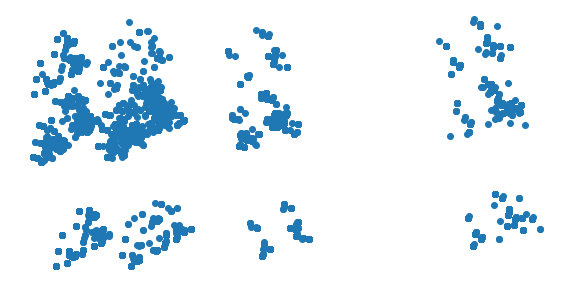

In [88]:

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(netflix)

plt.figure(figsize=(10,5))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

C:\Users\Vedhik\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Vedhik\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8807 samples in 0.001s...
[t-SNE] Computed neighbors for 8807 samples in 1.450s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8807
[t-SNE] Computed conditional probabilities for sample 2000 / 8807
[t-SNE] Computed conditional probabilities for sample 3000 / 8807
[t-SNE] Computed conditional probabilities for sample 4000 / 8807
[t-SNE] Computed conditional probabilities for sample 5000 / 8807
[t-SNE] Computed conditional probabilities for sample 6000 / 8807
[t-SNE] Computed conditional probabilities for sample 7000 / 8807
[t-SNE] Computed conditional probabilities for sample 8000 / 8807
[t-SNE] Computed conditional probabilities for sample 8807 / 8807
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.533863
[t-SNE] KL divergence after 300 iterations: 1.403045


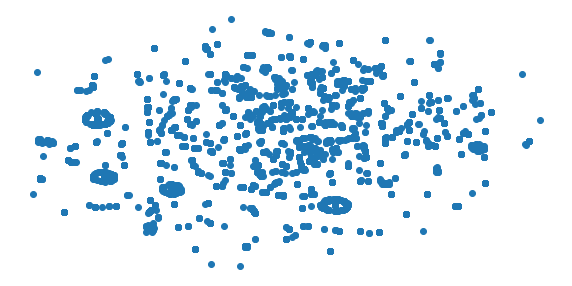

In [89]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=123)
tsne_results = tsne.fit_transform(netflix)

plt.figure(figsize=(10,5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 8807 samples in 0.002s...


C:\Users\Vedhik\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Vedhik\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 8807 samples in 1.429s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8807
[t-SNE] Computed conditional probabilities for sample 2000 / 8807
[t-SNE] Computed conditional probabilities for sample 3000 / 8807
[t-SNE] Computed conditional probabilities for sample 4000 / 8807
[t-SNE] Computed conditional probabilities for sample 5000 / 8807
[t-SNE] Computed conditional probabilities for sample 6000 / 8807
[t-SNE] Computed conditional probabilities for sample 7000 / 8807
[t-SNE] Computed conditional probabilities for sample 8000 / 8807
[t-SNE] Computed conditional probabilities for sample 8807 / 8807
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.360527
[t-SNE] KL divergence after 300 iterations: 1.245701


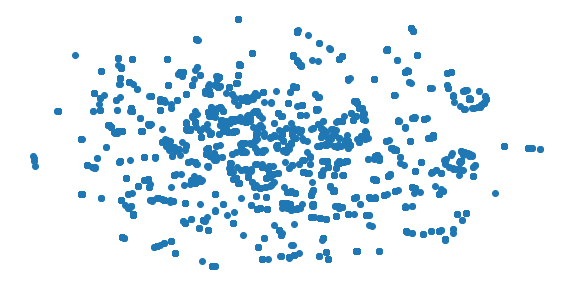

In [90]:
tsne = TSNE(n_components=2, verbose=1, perplexity=80, n_iter=300)
tsne_results = tsne.fit_transform(netflix)

plt.figure(figsize=(10,5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 8807 samples in 0.001s...


C:\Users\Vedhik\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Vedhik\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 8807 samples in 1.309s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8807
[t-SNE] Computed conditional probabilities for sample 2000 / 8807
[t-SNE] Computed conditional probabilities for sample 3000 / 8807
[t-SNE] Computed conditional probabilities for sample 4000 / 8807
[t-SNE] Computed conditional probabilities for sample 5000 / 8807
[t-SNE] Computed conditional probabilities for sample 6000 / 8807
[t-SNE] Computed conditional probabilities for sample 7000 / 8807
[t-SNE] Computed conditional probabilities for sample 8000 / 8807
[t-SNE] Computed conditional probabilities for sample 8807 / 8807
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.623817
[t-SNE] KL divergence after 300 iterations: 1.633803


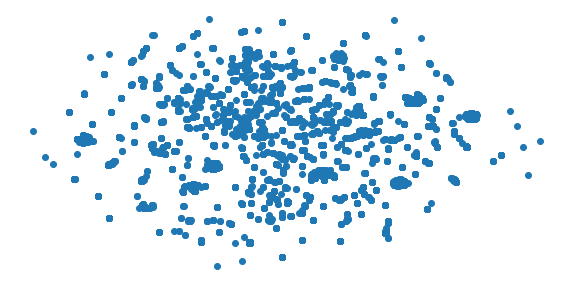

In [91]:
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=300)
tsne_results = tsne.fit_transform(netflix)

plt.figure(figsize=(10,5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


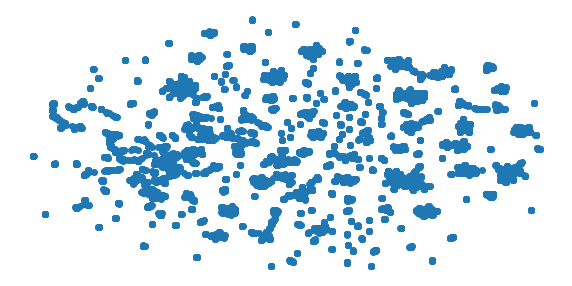

In [92]:
umap_results = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation').fit_transform(netflix)

plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

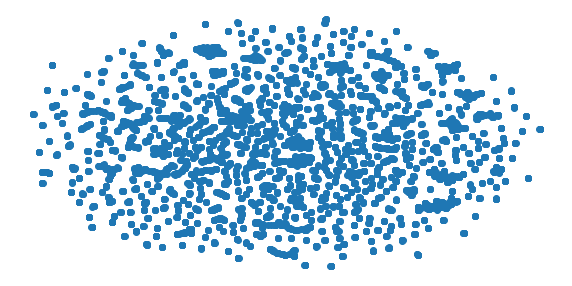

In [93]:
umap_results = umap.UMAP(n_neighbors=3, min_dist=0.3, metric='correlation').fit_transform(netflix)

plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

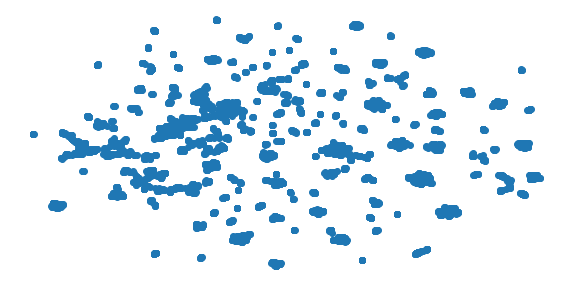

In [94]:
umap_results = umap.UMAP(n_neighbors=7, min_dist=0.3, metric='correlation').fit_transform(netflix)

plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()
     

In [ ]:
#the components of the different dimensionality reduction techniques doesn't have a ground truth to be compared to
#Given this, it looks like PCA has the most clear separation between clusters, so I will be using PCA     

In [95]:
pca = PCA(n_components=2, random_state=123)
pca_components = pca.fit_transform(netflix)

In [96]:
clusters=0
best=0
for i in range(2,15):
    labels = KMeans(n_clusters=i, random_state=123).fit_predict(pca_components)
    sil=metrics.silhouette_score(pca_components, labels, metric='euclidean')
    if sil>best:
        best=sil
        clusters=i
print('The Silhuette score with {} clusters is {}'.format(clusters, best))

The Silhuette score with 10 clusters is 0.6538633834517292


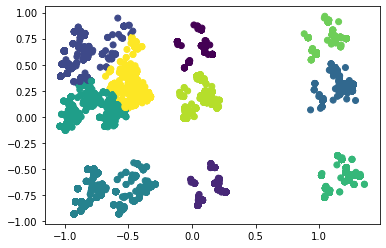

In [97]:
cluster= KMeans(n_clusters=10, random_state=123)

y_pred = cluster.fit_predict(pca_components)

plt.scatter(pca_components[:, 0], pca_components[:, 1], c=y_pred)
plt.show()

In [98]:
from sklearn.cluster import AgglomerativeClustering

linkage_methods = ["ward", "average", "complete"]
for i in linkage_methods:
    try:
        agg_cluster = AgglomerativeClustering(linkage=i, 
                                        affinity='cosine',
                                        n_clusters=10)


        clusters = agg_cluster.fit_predict(pca_components)

        print("Silhouette score of linkage method {}: {}".format(i,metrics.silhouette_score(pca_components, clusters, metric='euclidean')))
        print("------------------------------------------------")

    except:
        agg_cluster = AgglomerativeClustering(linkage=i, 
                                      affinity='euclidean',
                                      n_clusters=10)


        clusters = agg_cluster.fit_predict(pca_components)

        print("Silhouette score of linkage method {}: {}".format(i,metrics.silhouette_score(pca_components, clusters, metric='euclidean')))
        print("------------------------------------------------")


Silhouette score of linkage method ward: 0.6447025357658662
------------------------------------------------
Silhouette score of linkage method average: 0.5194362062428819
------------------------------------------------
Silhouette score of linkage method complete: 0.3885466972160916
------------------------------------------------


In [99]:

#It looks like the best linkage method is ward, so I will try to tune some parameters in there to get a better score
best=0
n_clusters=0
for i in range(2,15):
    agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=i)


    clusters = agg_cluster.fit_predict(pca_components)

    score=metrics.silhouette_score(pca_components, clusters, metric='euclidean')

    if score>best:
        best=score
        n_clusters=i
    else:
        continue

    print("Silhouette score of linkage method ward and {} clusters: {}".format(n_clusters,best))
    print("------------------------------------------------")

Silhouette score of linkage method ward and 2 clusters: 0.5209458407539334
------------------------------------------------
Silhouette score of linkage method ward and 4 clusters: 0.574391340341
------------------------------------------------
Silhouette score of linkage method ward and 5 clusters: 0.5863602508902028
------------------------------------------------
Silhouette score of linkage method ward and 6 clusters: 0.6414109666340021
------------------------------------------------
Silhouette score of linkage method ward and 10 clusters: 0.6447025357658662
------------------------------------------------


In [100]:
from sklearn.mixture import GaussianMixture

types=['full', 'tied', 'diag','spherical']
for i in types:
    gmm_cluster = GaussianMixture(n_components=10, random_state=123, covariance_type=i)

    clusters = gmm_cluster.fit_predict(pca_components)

    print("Silhouette score with covariance_type={}: {}".format(i,metrics.silhouette_score(pca_components, clusters, metric='euclidean')))
    print("------------------------------------------------------")

Silhouette score with covariance_type=full: 0.6133754808247658
------------------------------------------------------
Silhouette score with covariance_type=tied: 0.6131331969556878
------------------------------------------------------
Silhouette score with covariance_type=diag: 0.614765028575449
------------------------------------------------------
Silhouette score with covariance_type=spherical: 0.6100738136326875
------------------------------------------------------


In [104]:
n_clusters=0
best=0
for i in range(2,15):
    gmm_cluster = GaussianMixture(n_components=i, random_state=123, covariance_type='diag')

    clusters = gmm_cluster.fit_predict(pca_components)
    sil=metrics.silhouette_score(pca_components, clusters, metric='euclidean')
    if sil>best:
        best=sil
        n_clusters=i
print('The Silhuette score with {} clusters is {}'.format(n_clusters, best))

The Silhuette score with 7 clusters is 0.6356340827790208


# Results:

Based on visual inspection of the PCA, t-SNE, and UMAP components, I decided to utilize PCA for dimensionality reduction. Although there was no ground truth to which I could compare the graphs, I inspected each techniques’ components and found that PCA gave the most distinct separation. After this I analyzed the clustering ability of K-means, hierarchical clusters, and gaussian mixture algorithms. After hypertuning the parameters for each algorithm, I compared them using their silhouette scores. All three algorithms provided a silhouette score very close to 0.63- 0.65, this can be attributed to randomization and is not indicative of a significant difference. Any of these clustering algorithms will provide useful clusters of the Netflix titles. Given these results we can reject H01 where there is no significant difference across dimensionality reduction techniques and accept HA2 where there is no significant difference across clustering algorithms.

Discussion:

Given the silhouette scores, we can reasonably cluster the cleaned netflix dataset using either K-means, agglomerative clustering, or gaussian mixtures. However, the clustering ability for this model can still be improved by further data exploration and feature engineering. Some of the less important features can be removed from this dataset and others can be utilized. In the future, the description feature can be utilized to cluster the data set using word similarity across the different titles. 